### FRAUD DETECTION IN FINANCIAL TRANSACTIONS USING MACHINE LEARNING ON GOOGLE CLOUD

# Important Variables

* Trasaction Type: Is most important variable, Fruad is mostly found in TRANSFER and CASH_OUT transaction.Other types like PAYMENT or DEBIT rarely have fraud.
* Transaction Amount:  Fraudulent transactions often have higher amounts.
* Account Balance Changes:  Fraudulent transactions often show suspicios balace changes.  
                            Eg. A fraudulster may transfer money out, leaving their balance unchanged.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction import FeatureHasher
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [2]:
df = pd.read_csv("Synthetic_Financial_datasets_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Dataset Overview

In [3]:
df.shape

(6362620, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

* There is no null value present in the dataset

In [6]:
# Check for Duplicate Rows
print(f"No of Duplicate Rows: {df.duplicated().sum()}")

No of Duplicate Rows: 0


In [7]:
# Descriptive Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


# Exploratory Data Analysis

In [8]:
# Display settings
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style="whitegrid")

# Plotting settings
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

## Q.What types of transactions appear in the datasets and what are their frequencies?

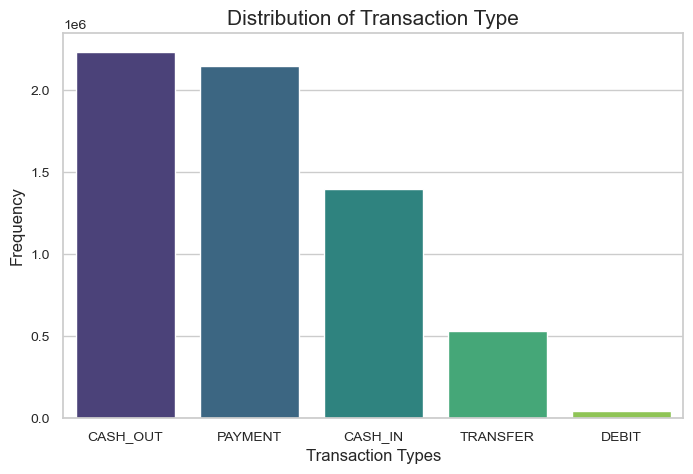

In [9]:
# Count the occurences of each transaction types
transaction_counts = df["type"].value_counts()

# Plot the distibution of transaction types
sns.barplot(x=transaction_counts.index, y = transaction_counts.values, palette="viridis")
plt.title("Distribution of Transaction Type")
plt.xlabel("Transaction Types")
plt.ylabel("Frequency")
plt.show()

### Insights

* The most common transaction types are 'CASH_OUT' and 'PAYMENT', while 'TRANSFER' and 'DEBIT' are less frequent.  

* This pattern might suggest that frauds are likely to occure in specific transaction type (such as 'CASH_OUT' or 'PAYMENT'), as this offer ways to withdraw and or funds.

In [10]:
df["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

## Q.Which transaction type has highest fraud percentage?

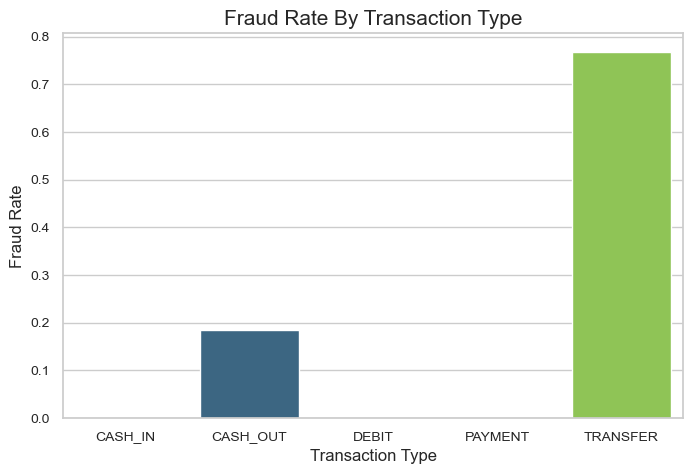

In [11]:
# Calculate the fraud rate for each transaction type
fraud_by_type = df.groupby('type')['isFraud'].mean() * 100

# Plot the fraud rate by the transaction type
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values,palette='viridis')
plt.title("Fraud Rate By Transaction Type")
plt.xlabel('Transaction Type')
plt.ylabel('Fraud Rate')
plt.show()

### Insights
* It appears that the fraud rate of all transaction types are extremely low, with the highest fraud rate being 1% for TRANSFER. This suggest that fraud is relatively rare across all transaction type, but transfer might be slightly more subsceptible to fraudulent activity compared to others.

* Given the very low fraud rates, This indicates the highly imbalenced dataset, which is typically in fraud detection problem. This will required techniques like oversampling or anamoly detection during model training to properly identify fraudulent transactions.

## Q.What is the distribution of amounts in fraudulent vs non-fraudulent transactions?

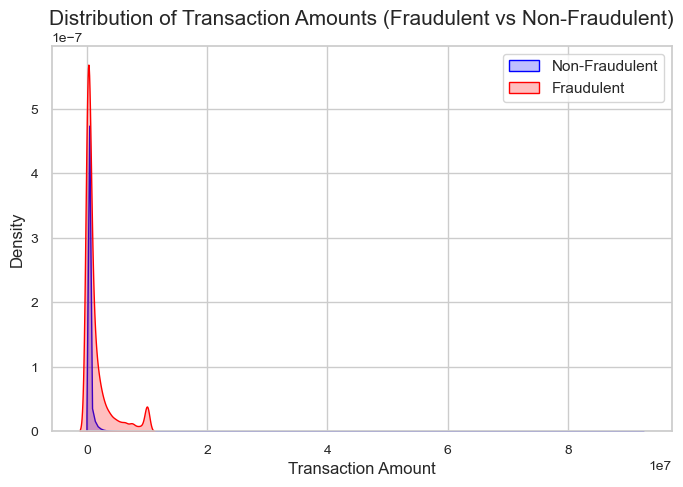

In [12]:
# Plot the distribution of transaction amount for fraudulent vs non-fraudulent transactions
sns.kdeplot(df[df['isFraud'] == 0]['amount'], label="Non-Fraudulent", fill=True, color="blue")
sns.kdeplot(df[df['isFraud'] == 1]['amount'], label="Fraudulent", fill=True, color="red")
plt.title("Distribution of Transaction Amounts (Fraudulent vs Non-Fraudulent)")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.legend()
plt.show()

### Insights
* Fraudulent have the significantly higher amount compared to non-fraudulent ones  
  * Non-Fraudulent Transaction- The distribution is highly skewed due to preference of some extremely large transactions.  
  * Fraudulent Transactions - The values of fraudulent transactions are higher. This indicates that fraudsters tends to focus on much larger transactions.
 

## Q.Are there any balance characteristics associated with fraud?

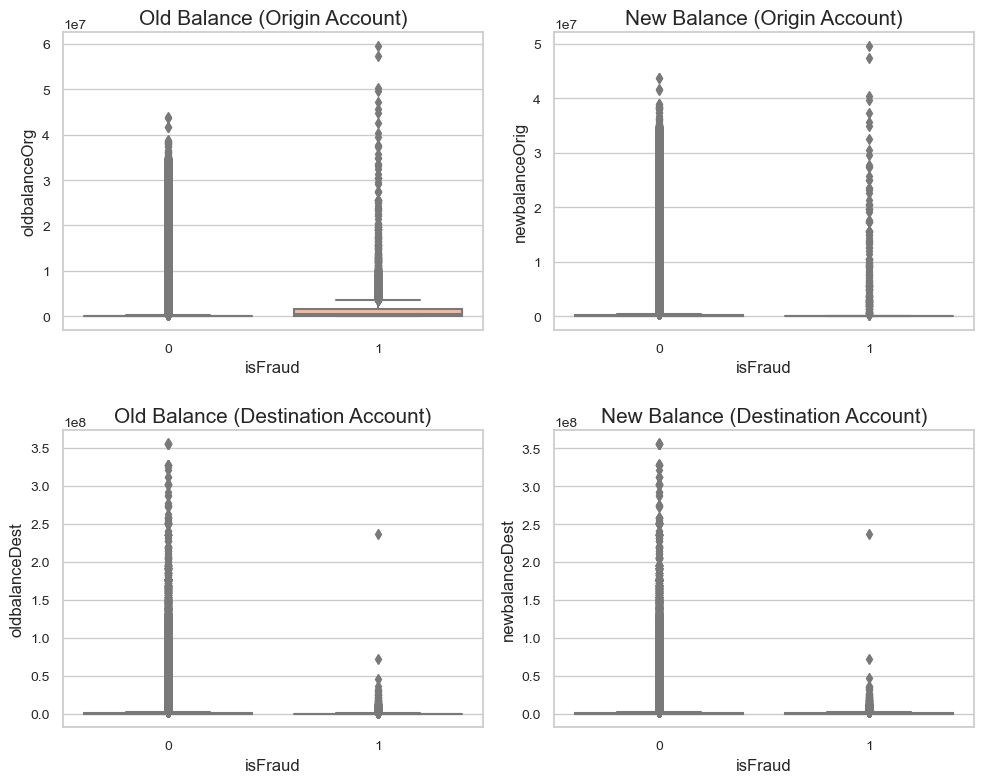

In [13]:
# Create boxplot to compare balances (old vs new) for fraudulent vs non-fraudulent transaction
plt.figure(figsize=(10,8))

# Old balance for the origin account
plt.subplot(2,2,1)
sns.boxplot(x='isFraud', y='oldbalanceOrg', data=df, palette='coolwarm')
plt.title("Old Balance (Origin Account)")

plt.subplot(2,2,2)
sns.boxplot(x='isFraud', y='newbalanceOrig', data=df, palette='coolwarm')
plt.title('New Balance (Origin Account)')

plt.subplot(2,2,3)
sns.boxplot(x='isFraud', y='oldbalanceDest', data=df, palette='coolwarm')
plt.title('Old Balance (Destination Account)')

plt.subplot(2,2,4)
sns.boxplot(x='isFraud', y='newbalanceDest', data=df, palette='coolwarm')
plt.title('New Balance (Destination Account)')

plt.tight_layout()
plt.show()

### Insights
* Old balance of origin account  
    * Fraudulent transactions (isFraud = 1) tent to have high starting balances.  
    * Non- fraudulent transactions (isFraud = 0) show a wider spread, including low balance.
* New balance of origin account  
    * After fraudulent transactions, the remaining balance in the origin accounts is significantly reduced.  
    * This suggest that fraudsters often drain the account or transfer a large portion of the funds.  
* Old balance of destination account  
     * Fraudlent transaction often involve destination acciunts that already have high balances.  
     * Non-fraudulent transaction involves wider range of balance.  
* New balance of destination account  
     * A key fraud pattern is sudden large increase in the balance of the destination account.  
     * This suggest that fraudulent transaction result in big deposits to certain accounts.  

* Changes in balances  
  * Fraudulent transaction shows more drastic changes in balances, particularly in the destination account, where there are 
    more significant increase in the 'new balance'. 

* These insight suggest that fraudulent transactions are often associated with larger account balance and more significant balance changes, which can be key feauters to focus on during fraud detection modeling.

# Q.How are fraudulent transactions distributed over time (steps)?

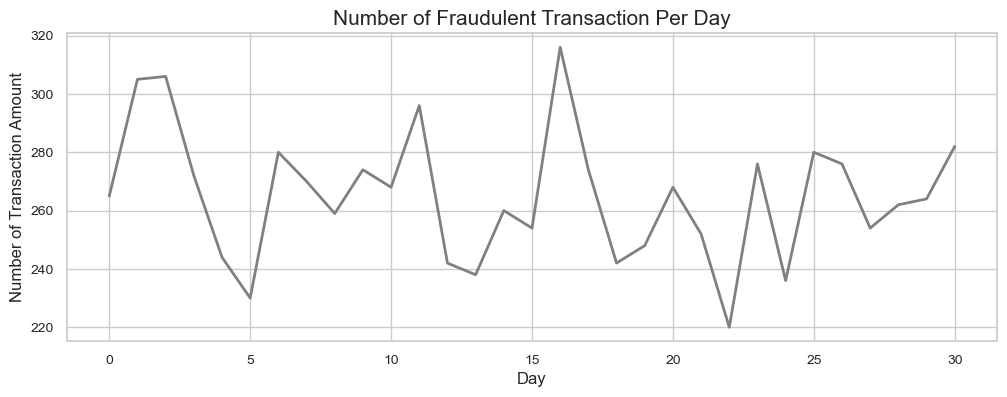

In [14]:
# Create the new column representing the day (each 24-hour period in the step count)
df["day"] = df["step"] // 24

# Group fraudulent transaction by day
fraud_per_day = df[df["isFraud"] ==1].groupby("day").size()

# Plot the fraudulent transaction per day
plt.figure(figsize= (12,4))
fraud_per_day.plot(kind= 'line', color = 'grey', linewidth = 2)
plt.title("Number of Fraudulent Transaction Per Day")
plt.xlabel("Day")
plt.ylabel("Number of Transaction Amount")
plt.show()

### Insights
* Consistent Fraud Levels: Fraudulent transaction counts reamins stable across days, including steady fraud activity without significant daily fluctuations.  

* Uniform Fraud Distribution: The absence of extreme peacks or drops suggest that fraudulent activity is evenly distributed, possibly reflicting realistic, continuous fraud attempts rather than event-based spike.

### Fraud vs Non Fraud

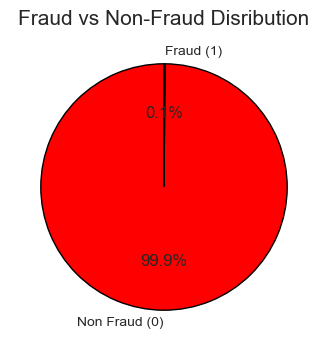

In [15]:

fraud_counts = df["isFraud"].value_counts()

labels = ["Non Fraud (0)","Fraud (1)"]

colors = ["red","lightblue"]

plt.figure(figsize=(4,4))
plt.pie(fraud_counts, labels=labels, autopct="%1.1f%%", colors = colors,startangle=90,wedgeprops={"edgecolor":"black"})

plt.title("Fraud vs Non-Fraud Disribution")

plt.show()

In [16]:
fraud_counts

0    6354407
1       8213
Name: isFraud, dtype: int64

# Correlation

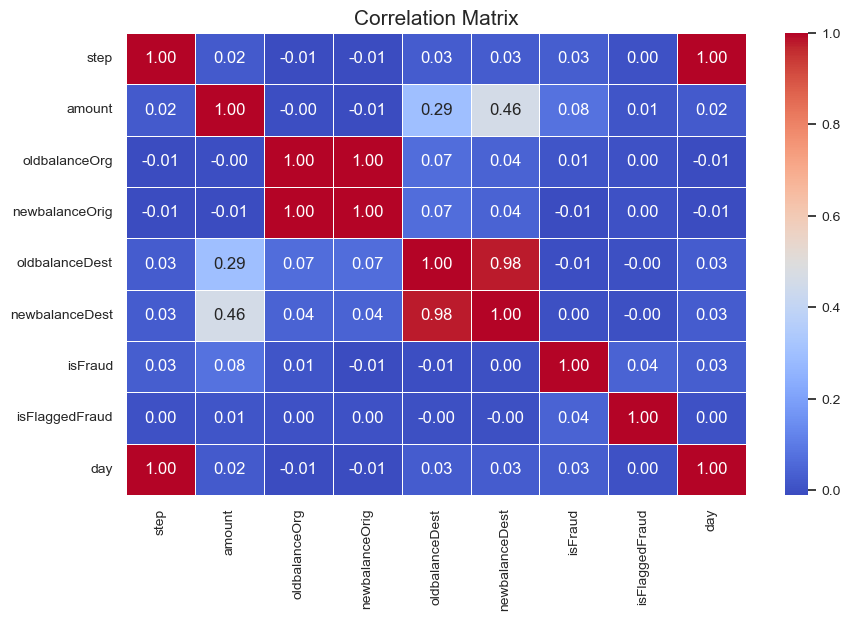

In [17]:
# Select only numerical columns for correlation calculations.
numerical_col = df.select_dtypes(include=['float64','int64']).columns

# Compute the correlation matrix only for numerical column
correlation_matrix = df[numerical_col].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [18]:
correlation_matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day
step,1.00,0.02,-0.01,-0.01,0.03,0.03,0.03,0.00,1.00
amount,0.02,1.00,-0.00,-0.01,0.29,0.46,0.08,0.01,0.02
oldbalanceOrg,-0.01,-0.00,1.00,1.00,0.07,0.04,0.01,0.00,-0.01
newbalanceOrig,-0.01,-0.01,1.00,1.00,0.07,0.04,-0.01,0.00,-0.01
oldbalanceDest,0.03,0.29,0.07,0.07,1.00,0.98,-0.01,-0.00,0.03
newbalanceDest,0.03,0.46,0.04,0.04,0.98,1.00,0.00,-0.00,0.03
isFraud,0.03,0.08,0.01,-0.01,-0.01,0.00,1.00,0.04,0.03
isFlaggedFraud,0.00,0.01,0.00,0.00,-0.00,-0.00,0.04,1.00,0.00
day,1.00,0.02,-0.01,-0.01,0.03,0.03,0.03,0.00,1.00


### Insights
* oldbalanceDesk and newbalanceDesk is highly correlated (0.98), suggesting that they capture similar information.  
* amount has moderated correlation with newbalanceDesk(0.46), indicating that higher transaction amount tend to correlate with higher destination balances.  
* No significant correlation between isFraud and other variables, which suggests that fraud detection is not easily linked to balance amounts alone.

# Feature Engineering

In [19]:
# Creating new feature: balance difference for origin (oldbalanceOrg-newbalanceOrig)
df["balance_diff_org"] = df["oldbalanceOrg"]-df["newbalanceOrig"]

# Creating new feature: balance difference for destination (oldbalanceDest - newbalanceDest)
df["balance_diff_dest"] = df["oldbalanceDest"]-df["newbalanceDest"]

* This feature helps in detecting fraudulent transactions where the expected balance change does not match the transaction amount

In [20]:
# Creating new feature: rate of balance change for origin
df["balance_change_rate_org"] = (df["oldbalanceOrg"] - df["newbalanceOrig"]) / df["oldbalanceOrg"]

# Creating new frature: rate of balance change for destination
df["balance_change_rate_dest"] = (df["oldbalanceDest"] - df["newbalanceDest"]) / df["oldbalanceDest"]

* This calculates the proportion of the balance change for both the origin and destination.
* Helps identify unusual transaction behavior, such as:
  * if a user transfer almost all of their money, it could be suspecious.
  * if a destination account receives a large proportion of its balance suddenly, it might be part of fraud.

In [21]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,balance_diff_org,balance_diff_dest,balance_change_rate_org,balance_change_rate_dest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,9839.64,0.00,0.06,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,1864.28,0.00,0.09,NaN
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,181.00,0.00,1.00,NaN
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,181.00,21182.00,1.00,1.00
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,11668.14,0.00,0.28,NaN


# Preprocessing

In [22]:
# Drop the original column to save memory
df.drop(columns = ['nameOrig','nameDest'], inplace=True)

In [23]:
# Label Encoding for type
le_type = LabelEncoder()
df["type"] = le_type.fit_transform(df["type"])

In [24]:
# Cyclic Encoding
# Define the period (day in a month)
period = 30

# Apply sine and cosine transformations
df["day_sin"] = np.sin(2 * np.pi *  df["day"]/period)
df["day_cos"] = np.cos(2 * np.pi * df["day"]/period)

# Drop the original 'day' column
df.drop(columns=["day"],inplace=True)

In [25]:
df.isnull().sum()

step                              0
type                              0
amount                            0
oldbalanceOrg                     0
newbalanceOrig                    0
oldbalanceDest                    0
newbalanceDest                    0
isFraud                           0
isFlaggedFraud                    0
balance_diff_org                  0
balance_diff_dest                 0
balance_change_rate_org     2088985
balance_change_rate_dest    2317282
day_sin                           0
day_cos                           0
dtype: int64

* Fill null values

In [26]:
df["balance_change_rate_org"] = df["balance_change_rate_org"].fillna(0)
df["balance_change_rate_dest"] = df["balance_change_rate_dest"].fillna(0)

In [27]:
# Drop step columns
df.drop(columns='step', inplace=True)

In [28]:
df.columns

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'balance_diff_org',
       'balance_diff_dest', 'balance_change_rate_org',
       'balance_change_rate_dest', 'day_sin', 'day_cos'],
      dtype='object')

In [29]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# List numeriacal features to scale
numerical_col = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest','balance_diff_org', 'balance_diff_dest', 'balance_change_rate_org',
       'balance_change_rate_dest']

# scale numerical fratures
scaler = RobustScaler()
df[numerical_col] = scaler.fit_transform(df[numerical_col])

In [30]:
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_diff_org,balance_diff_dest,balance_change_rate_org,balance_change_rate_dest,day_sin,day_cos
0,3,-0.33,1.45,1.11,-0.14,-0.19,0,0,0.97,0.00,0.07,0.00,0.00,1.00
1,3,-0.37,0.07,0.13,-0.14,-0.19,0,0,0.18,0.00,0.10,0.00,0.00,1.00
2,4,-0.38,-0.13,0.00,-0.14,-0.19,1,0,0.02,0.00,1.19,0.00,0.00,1.00
3,1,-0.38,-0.13,0.00,-0.12,-0.19,1,0,0.02,0.14,1.19,6.99,0.00,1.00
4,3,-0.32,0.25,0.21,-0.14,-0.19,0,0,1.15,0.00,0.33,0.00,0.00,1.00
